<a href="https://colab.research.google.com/github/vperezguti/Resp-Experto-data---caso-practico/blob/main/Modelo_MobileNetV2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

#Plot Images
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

folder_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'
img_height = 224
img_width = 224
batch_size = 41
batch_size_val = 1
    
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size_val)


class_names = train_ds.class_names

Found 1148 files belonging to 10 classes.
Using 919 files for training.
Found 1148 files belonging to 10 classes.
Using 229 files for validation.


In [ ]:
mobileNetV2 = tf.keras.models.load_model('/content/drive/MyDrive/Curso Data Science/mi_proyecto/MobileNetV2_v2.h5')

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    RandomRotation(0.2),
    RandomZoom(0.1),
  ])

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************



Según:

https://www.tensorflow.org/tutorials/images/transfer_learning


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(41, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(41, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(41, 10)


In [ ]:
inputs = tf.keras.Input(shape=(img_height,img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelv2_2 = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
modelv2_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
modelv2_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
initial_epochs = 100

loss0, accuracy0 = modelv2_2.evaluate(val_ds)

229/229 [==============================] - 14s 55ms/step - loss: 2.6434 - accuracy: 0.0830


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.64
initial accuracy: 0.08


In [ ]:
history = modelv2_2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
23/23 [==============================] - 56s 2s/step - loss: 2.5870 - accuracy: 0.1121 - val_loss: 2.3377 - val_accuracy: 0.1179
Epoch 2/100
23/23 [==============================] - 50s 2s/step - loss: 2.3731 - accuracy: 0.1763 - val_loss: 2.2265 - val_accuracy: 0.1790
Epoch 3/100
23/23 [==============================] - 51s 2s/step - loss: 2.1972 - accuracy: 0.2285 - val_loss: 2.1218 - val_accuracy: 0.2402
Epoch 4/100
23/23 [==============================] - 50s 2s/step - loss: 2.1391 - accuracy: 0.2786 - val_loss: 2.0388 - val_accuracy: 0.2795
Epoch 5/100
23/23 [==============================] - 52s 2s/step - loss: 2.0139 - accuracy: 0.3069 - val_loss: 1.9531 - val_accuracy: 0.3362
Epoch 6/100
23/23 [==============================] - 52s 2s/step - loss: 1.9435 - accuracy: 0.3330 - val_loss: 1.8794 - val_accuracy: 0.3624
Epoch 7/100
23/23 [==============================] - 53s 2s/step - loss: 1.8284 - accuracy: 0.3841 - val_loss: 1.8070 - val_accuracy: 0.4105
Epoch 8/100
2

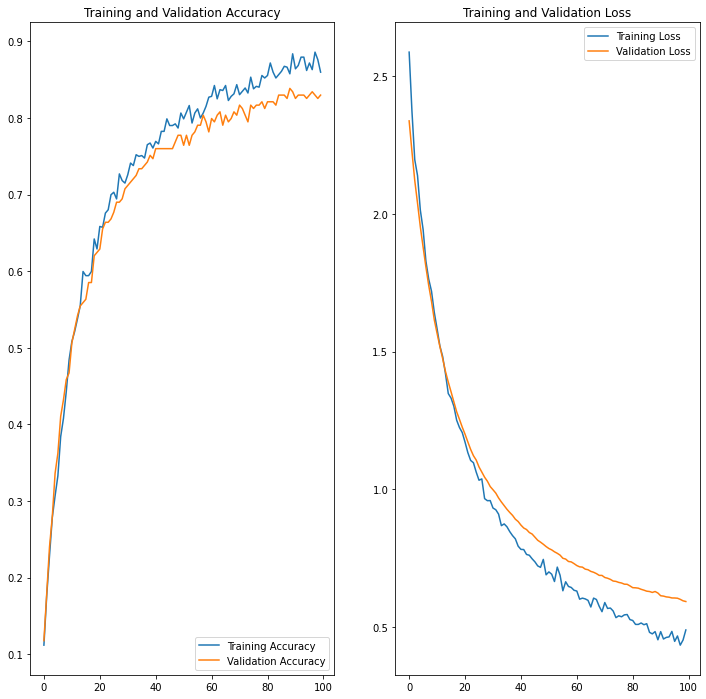

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 66ms/step


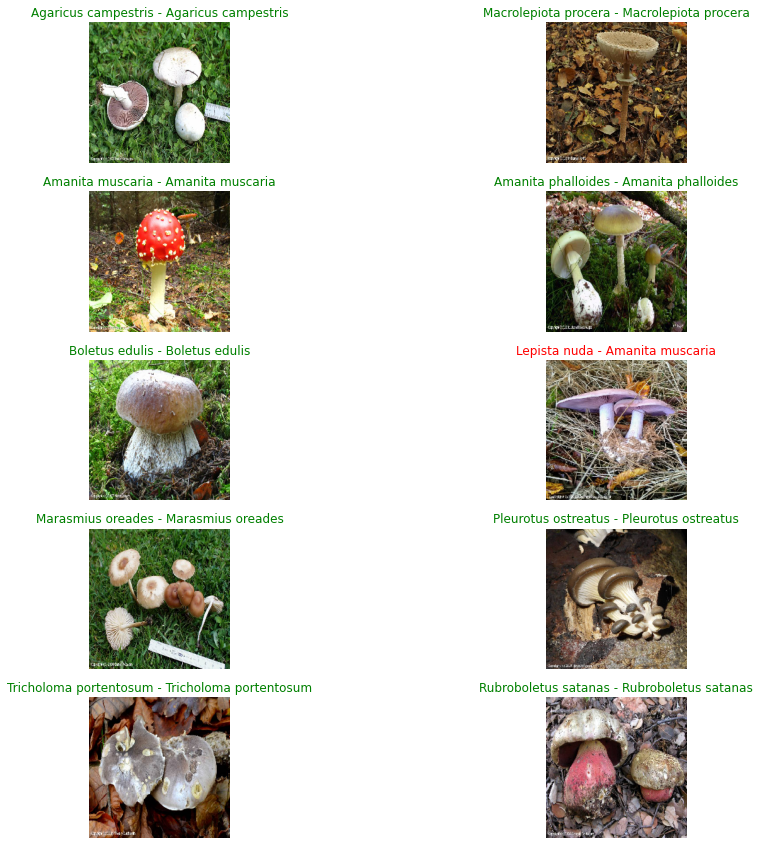

In [ ]:
predict_dict = {}
plt.figure(figsize=(15,15))
i = 1
for nombre, url in datos_test.items():
  prediccion = predict_seta(img_height, img_width, class_names, mobileNetV2, url)
  predict_dict[nombre] = prediccion[0]
  ax = plt.subplot(5,2,i)
  plt.imshow(prediccion[1])
  if nombre == prediccion[0]:
    plt.title(nombre+" - "+prediccion[0], color = 'g')
  else:  
    plt.title(nombre+" - "+prediccion[0], color = 'r')
  plt.axis("off")
  i += 1
#print(predict_dict)

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************



****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************





***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************




***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************




***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [ ]:
# Creamos un diccionario con las fotos
datos_test = {'Agaricus campestris': 'https://www.mycodb.fr/photos/Agaricus_campestris_2003_dr_1.jpg', 
              'Macrolepiota procera': 'https://www.mycodb.fr/photos/Macrolepiota_procera_2014_df_1.jpg', 
              'Amanita muscaria': 'https://www.mycodb.fr/photos/Amanita_muscaria_2005_ov_2.jpg', 
              'Amanita phalloides': 'https://www.mycodb.fr/photos/Amanita_phalloides_2011_jpa_1.jpg', 
              'Boletus edulis': 'https://www.mycodb.fr/photos/Boletus_edulis_2007_ov_1.jpg', 
              'Lepista nuda': 'https://www.mycodb.fr/photos/Lepista_nuda_2019_db_1.jpg', 
              'Marasmius oreades': 'https://www.mycodb.fr/photos/Marasmius_oreades_2000_dr_1.jpg', 
              'Pleurotus ostreatus': 'https://www.mycodb.fr/photos/Pleurotus_ostreatus_2015_hm_1.jpg', 
              'Tricholoma portentosum': 'https://www.mycodb.fr/photos/Tricholoma_portentosum_2014_td_3.jpg', 
              'Rubroboletus satanas': 'https://www.mycodb.fr/photos/Rubroboletus_satanas_2006_ar_1.jpg'}

In [ ]:
#Crearemos una función para el cálculo 
def predict_seta(img_height, img_width, clases, modelo, img_url):
  img_path = tf.keras.utils.get_file('mushroom_image'+str(random.randint(0, 999)), origin=img_url)

  img = tf.keras.preprocessing.image.load_img(
      img_path, target_size=(img_height, img_width, 3)
  )

#plt.imshow(img)

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = modelo.predict(img_array)

  predictions_sigmoid = tf.nn.sigmoid(predictions)
  score = tf.nn.softmax(predictions[0])

  return clases[np.argmax(score)], img